# Proyek Klasifikasi Gambar: Satellite


* Nama: Khoirotun Hisan
* Email: hisan344@gmail.com
* ID Dicoding: khoesan

In [2]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print(tf.__version__)

2.18.0


# Data Preparation, Preprocessing

In [23]:
import os
import shutil

cloudy_dir = '/kaggle/input/satellite-image-classification/data/cloudy'
water_dir = '/kaggle/input/satellite-image-classification/data/water'
combined_dir = '/kaggle/working/satellite/dataset'

os.makedirs(combined_dir, exist_ok=True)

shutil.copytree(cloudy_dir, os.path.join(combined_dir, 'cloudy'), dirs_exist_ok=True)

shutil.copytree(water_dir, os.path.join(combined_dir, 'water'), dirs_exist_ok=True)

'/kaggle/working/satellite/dataset/water'

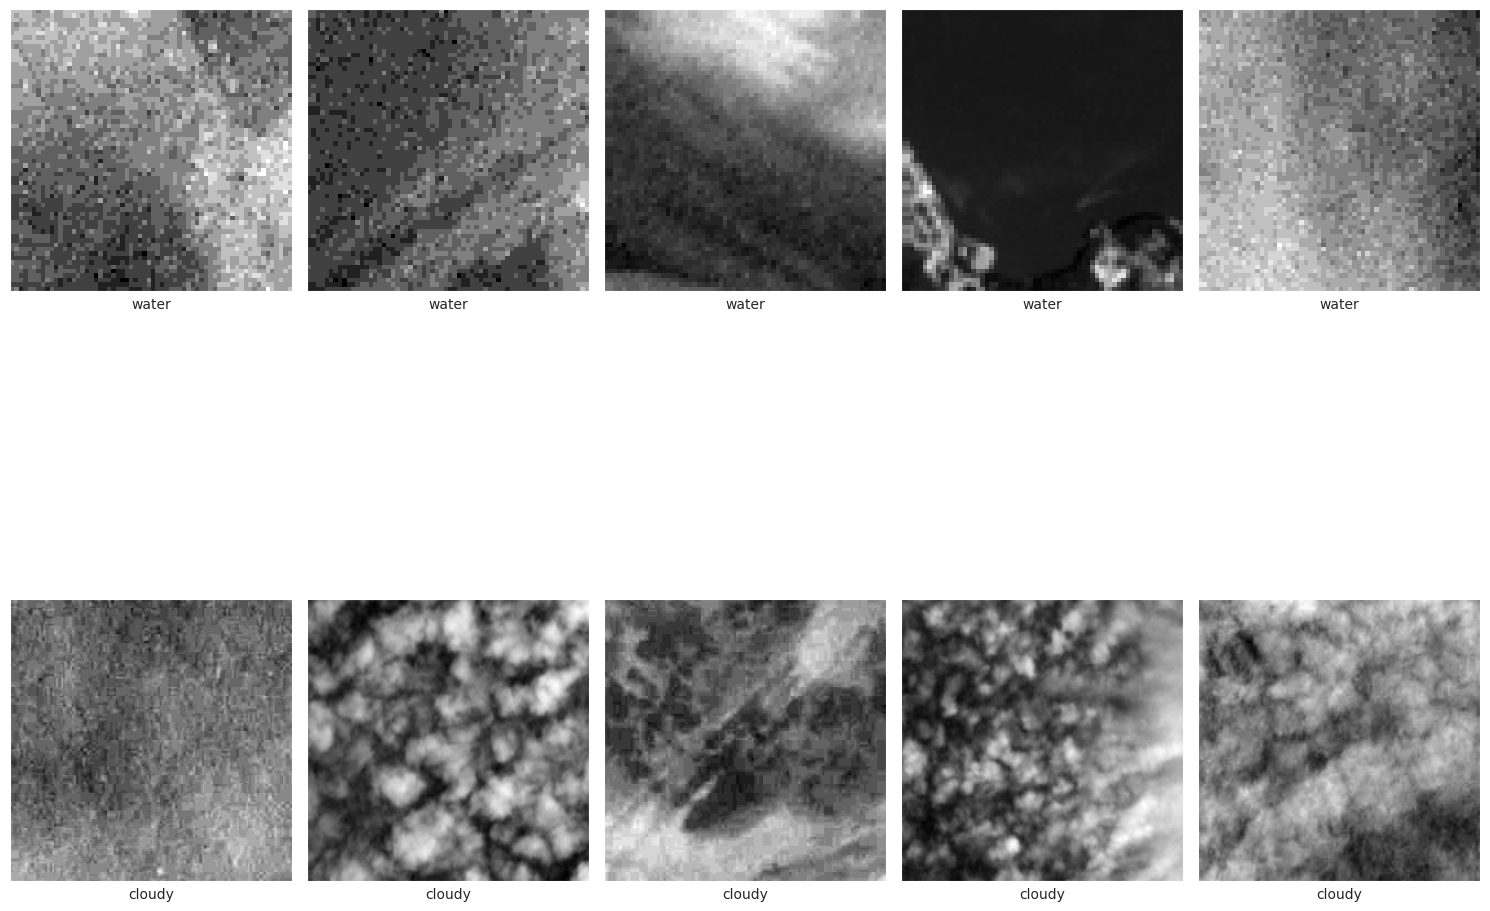

In [24]:
lung_image = {}
 
path = "satellite/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))
 
path_sub = "satellite/dataset/"
 
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))
 
for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)
 
    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
 
fig.tight_layout()

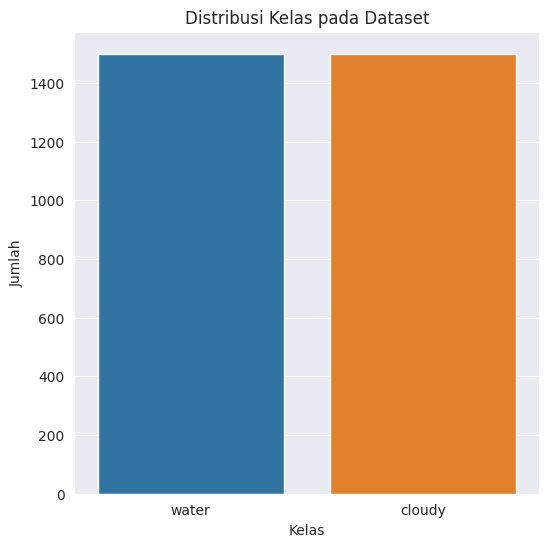

In [26]:
import seaborn as sns

lung_path = "satellite/dataset/"
 
file_name = []
labels = []
full_path = []
 
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)
 
distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})
 
Label = distribution_train['labels']
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x='labels', data=distribution_train)
plt.title('Distribusi Kelas pada Dataset')
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.show()

In [27]:
mypath= 'satellite/dataset/'
 
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)
 
# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
cloudy    1500
water     1500
dtype: int64

In [28]:
X= df['path']
y= df['labels']
 
# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

df_all = pd.concat([df_tr, df_te], ignore_index=True)
 
print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')
 
# Cek sampel data
print(df_all.sample(5))
 
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels
test   cloudy     309
       water      291
train  cloudy    1191
       water     1209
dtype: int64 


                                          path  labels    set
1071  satellite/dataset/water/SeaLake_2176.jpg   water  train
214    satellite/dataset/water/SeaLake_638.jpg   water  train
1374  satellite/dataset/cloudy/train_25659.jpg  cloudy  train
540   satellite/dataset/water/SeaLake_2258.jpg   water  train
2825  satellite/dataset/cloudy/train_30056.jpg  cloudy   test


In [30]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])
 
    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))
 
    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)
 
    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [32]:
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"
 
train_cloudy = os.path.join(TRAIN_DIR + '/cloudy')
train_water = os.path.join(TRAIN_DIR + '/water')
test_cloudy = os.path.join(TEST_DIR + '/cloudy')
test_water = os.path.join(TEST_DIR + '/water')
 
print("Total number of cloudy images in training set: ",len(os.listdir(train_cloudy)))
print("Total number of water images in training set: ",len(os.listdir(train_water)))
print("Total number of cloudy images in test set: ",len(os.listdir(test_cloudy)))
print("Total number of water images in test set: ",len(os.listdir(test_water)))

Total number of cloudy images in training set:  1191
Total number of water images in training set:  1209
Total number of cloudy images in test set:  309
Total number of water images in test set:  291


In [33]:
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)
 
train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='binary',
                                              subset='training',
                                              shuffle=True)
 
validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                color_mode="grayscale",
                                                   class_mode='binary',
                                                   subset='validation',
                                                   shuffle=False)
 
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='binary',
                                                  shuffle=False)

Found 1921 images belonging to 2 classes.
Found 479 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


# Modelling

In [34]:
model_1 = Sequential()
 
# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))
 
# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))
 
# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))
 
# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))
 
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_1.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################
 
######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='binary_crossentropy',
                metrics=['accuracy'])
 
# Summary of the Model Architecture
print(model_1.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-24 14:49:11.649693: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 32)          │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,327,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,402,881 (5.35 MB)

 Trainable params: 1,402,689 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


In [43]:
count_cloudy, count_water = len(os.listdir(train_cloudy)), len(os.listdir(train_water))
weight_0 = (1 / count_cloudy) * (count_cloudy + count_water) / 2.0
weight_1 = (1 / count_water) * (count_cloudy + count_cloudy) / 2.0
 
class_weights = {0 : weight_0, 1 : weight_1}
 
%time
 
# Fitting / training model
history_1 = model_1.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9408 - loss: 0.1866 - val_accuracy: 0.5825 - val_loss: 25.6776
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9520 - loss: 0.1692 - val_accuracy: 0.7996 - val_loss: 3.1547
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9490 - loss: 0.1530 - val_accuracy: 0.6159 - val_loss: 12.1659
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9539 - loss: 0.1398 - val_accuracy: 0.8601 - val_loss: 0.7131
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9490 - loss: 0.1528 - val_accuracy: 0.5031 - val_loss: 39.1182
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9613 - loss: 0.1269 - val_accuracy: 0.8267 - val_loss: 0.4766
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9674 - loss: 0.1191 - val_accuracy: 0.4969 - val_loss: 1.3180
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step -

# Evaluasi dan Visualisasi

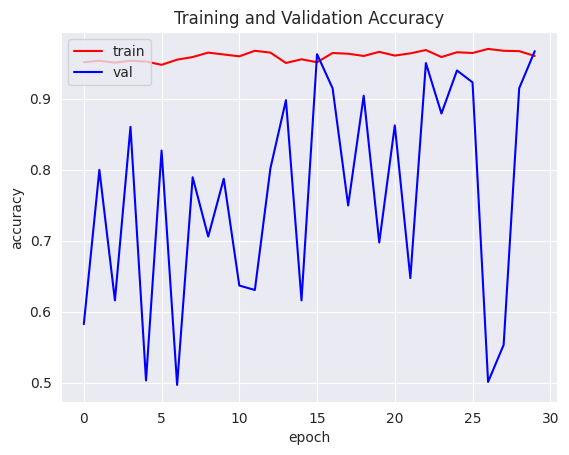

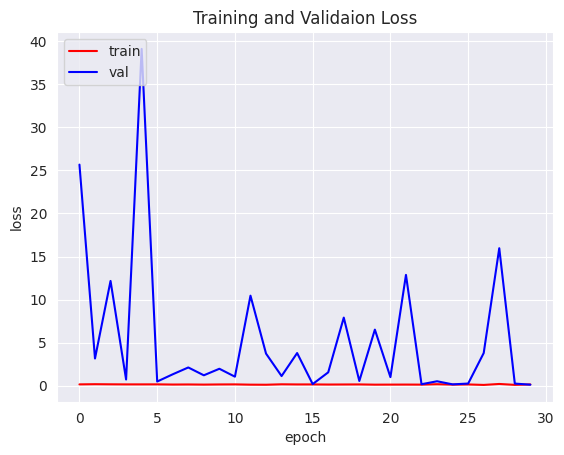

In [44]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
 
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

      Cloudy     0.9901    0.9709    0.9804       309
       Water     0.9697    0.9897    0.9796       291

    accuracy                         0.9800       600
   macro avg     0.9799    0.9803    0.9800       600
weighted avg     0.9802    0.9800    0.9800       600



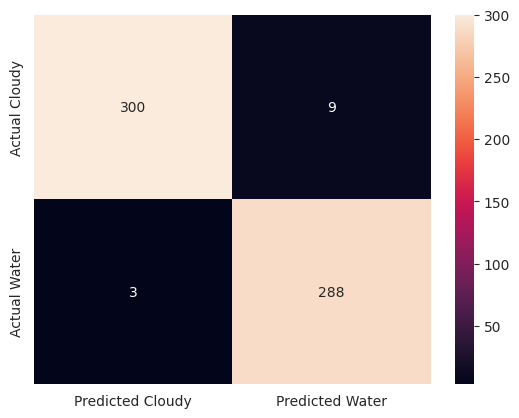

In [45]:
test_generator.reset()
 
preds_1 = model_1.predict(test_generator,verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1
 
# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),index=["Actual Cloudy", "Actual Water"],
columns=["Predicted Cloudy", "Predicted Water"])
sns.heatmap(cm,annot=True,fmt="d")
 
# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['Cloudy','Water'], digits=4))

# Konversi Model

In [56]:
model_1.export("saved_model")

os.makedirs("tflite", exist_ok=True)
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)
labels = ["cloudy", "water"]
with open("tflite/label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138018525719888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138018525719120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138018525720848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138018525720272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138018525718928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138018525721808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138018525718736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138020699458256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138020699457488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138020699457872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138018516474704: Te

W0000 00:00:1745515793.388439      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745515793.388506      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [58]:
import subprocess

with open('requirements.txt', 'w') as f:
    subprocess.run(['pip', 'freeze'], stdout=f)

print("requirements.txt telah dibuat.")

requirements.txt telah dibuat.


In [59]:
import shutil

folder_path = '/kaggle/working/'

zip_path = '/kaggle/working/satellite.zip'

shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)

print(f"Folder telah dikompres menjadi {zip_path}")


Folder telah dikompres menjadi /kaggle/working/satellite.zip


In [66]:
import shutil

# Tentukan path folder yang ingin dikompres
folder_path = '/kaggle/working/satellite'  # Ganti dengan path folder yang sesuai

# Tentukan path output ZIP
zip_path = '/kaggle/working/satellite.zip'

# Mengompres folder menjadi file ZIP
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)

print(f"Folder telah dikompres menjadi {zip_path}")

Folder telah dikompres menjadi /kaggle/working/satellite.zip
